In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import json
import networkx as nx
from sklearn import preprocessing

In [6]:
import os

In [11]:
path = "C:/Users/18565/Desktop/Classes/VA/Project/Code/VA-Project/data/Lekagul Sensor Data.csv"

In [12]:
df = pd.read_csv(path)

In [15]:
df.describe()

,Timestamp,car-id,car-type,gate-name
count,171477,171477,171477,171477
unique,170298,18708,7,40
top,2015-07-31 12:00:02,20154519024544-322,1,general-gate7
freq,5,281,67698,16119


In [17]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index("Timestamp",inplace=True)

In [18]:
def create_json(df):
    r"""retruns dictionary with keys data, edges and nodes 
        args:
        df (pd.DataFrame) : Lekagul Sensor Data 
    """
    pbar = tqdm(total=len(df))
    pbar.set_description("Data Processing :")

    car_ids = np.unique(df['car-id'])
    data_dic = {"data":[],"edges":None}
    data_dic["nodes"] = list(np.unique(df['gate-name']))
    all_edge_names = []
    for car_id in car_ids:
        row_data = {'car-id':car_id,'path_taken':[]}
        car_data = df[df['car-id']==car_id]
        row_data["car_type"] = np.unique(car_data['car-type'])[0]
        row_data['enter_date'] = str(car_data.index[0])
        row_data['exit_date'] = str(car_data.index[-1])
        total_time = car_data.index[-1]-car_data.index[0]
        total_time = total_time.total_seconds()/60
        row_data['total_in_time'] = round(total_time,2)
        for ind in range(1,len(car_data)):
            dic_key =car_data['gate-name'].iloc[ind-1]+ " to " +car_data['gate-name'].iloc[ind]
            delta = car_data.index[ind]-car_data.index[ind-1]
            delta = delta.total_seconds()/60
            
            row_data['path_taken'].append({dic_key:round(delta,2)})
            if dic_key not in all_edge_names:
                all_edge_names.append(dic_key)
        data_dic["data"].append(row_data)
        pbar.update(len(car_data))
    data_dic['edges'] =  all_edge_names
    pbar.close()
    return data_dic

In [19]:
data_json = create_json(df)

Data Processing :: 100%|██████████| 171477/171477 [03:53<00:00, 733.18it/s] 


In [20]:
def seperate_cartype_data(data):
    r"""returns data separated by cartype
        Args:
            Data (dictionary) : dic returned by create_json function"""
    new_dic = {'1':[], '2':[], '2P':[], '3':[], '4':[], '5':[], '6':[]}
    for one_car in data['data']:
        new_dic[one_car['car_type']].append(one_car)
        data['data'] = new_dic
    return data
    

In [21]:
data = seperate_cartype_data(data_json)

In [22]:
with open("data.json", "w") as outfile: 
    json.dump(data, outfile)

In [23]:
def get_edges(data):
    r"""returns normal and selfloop edges of a specific cartype
        args:
            data (dictionary) : dictionary data of a specific cartype"""
    edges = {"normal":{},"selfloop":{}}
    for car in data:
        for path in car['path_taken']:
            for key in path.keys():
                if (key.split(" ")[0]!=key.split(" ")[2]):
                    if key in edges['normal'].keys():
                        edges['normal'][key] += path[key]
                    else:
                        edges['normal'][key] = path[key]
                else:
                    if key in edges['selfloop'].keys():
                        edges['selfloop'][key] += path[key]
                    else:
                        edges['selfloop'][key] = path[key]
                    
    return edges

In [24]:
all_edges = get_edges(data_json['data']['1']) 

In [25]:
n_edge_weights = preprocessing.normalize(np.array(list(all_edges['normal'].values())).reshape(1,len(list(all_edges['normal'].values()))))
sl_edge_weights = preprocessing.normalize(np.array(list(all_edges['selfloop'].values())).reshape(1,len(list(all_edges['selfloop'].values()))))

In [27]:
n_edge_names = [(key.split(" ")[0],key.split(" ")[2]) for key in all_edges['normal'].keys()]
sl_edge_names = [(key.split(" ")[0],key.split(" ")[2]) for key in all_edges['selfloop'].keys()]

In [31]:
graph = nx.DiGraph()

In [32]:
graph.add_edges_from(n_edge_names)
graph.add_edges_from(sl_edge_names)

In [33]:
from matplotlib.cm import ScalarMappable

In [34]:
self_nodes =[i[0] for i in sl_edge_names ]

In [35]:
# create list of all nodes and a weight array that gives the time spend at that node
node_sizes = []
all_nodes = []
for j in graph.nodes():
    if j in self_nodes:
        node_sizes.append(sl_edge_weights[0][self_nodes.index(j)])
        all_nodes.append(j)
    else:
        node_sizes.append(0)
        all_nodes.append(j)

In [36]:
node_weights = node_sizes + min(sl_edge_weights[0])

In [37]:
node_weights = node_weights*30000

C:\Users\18565\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


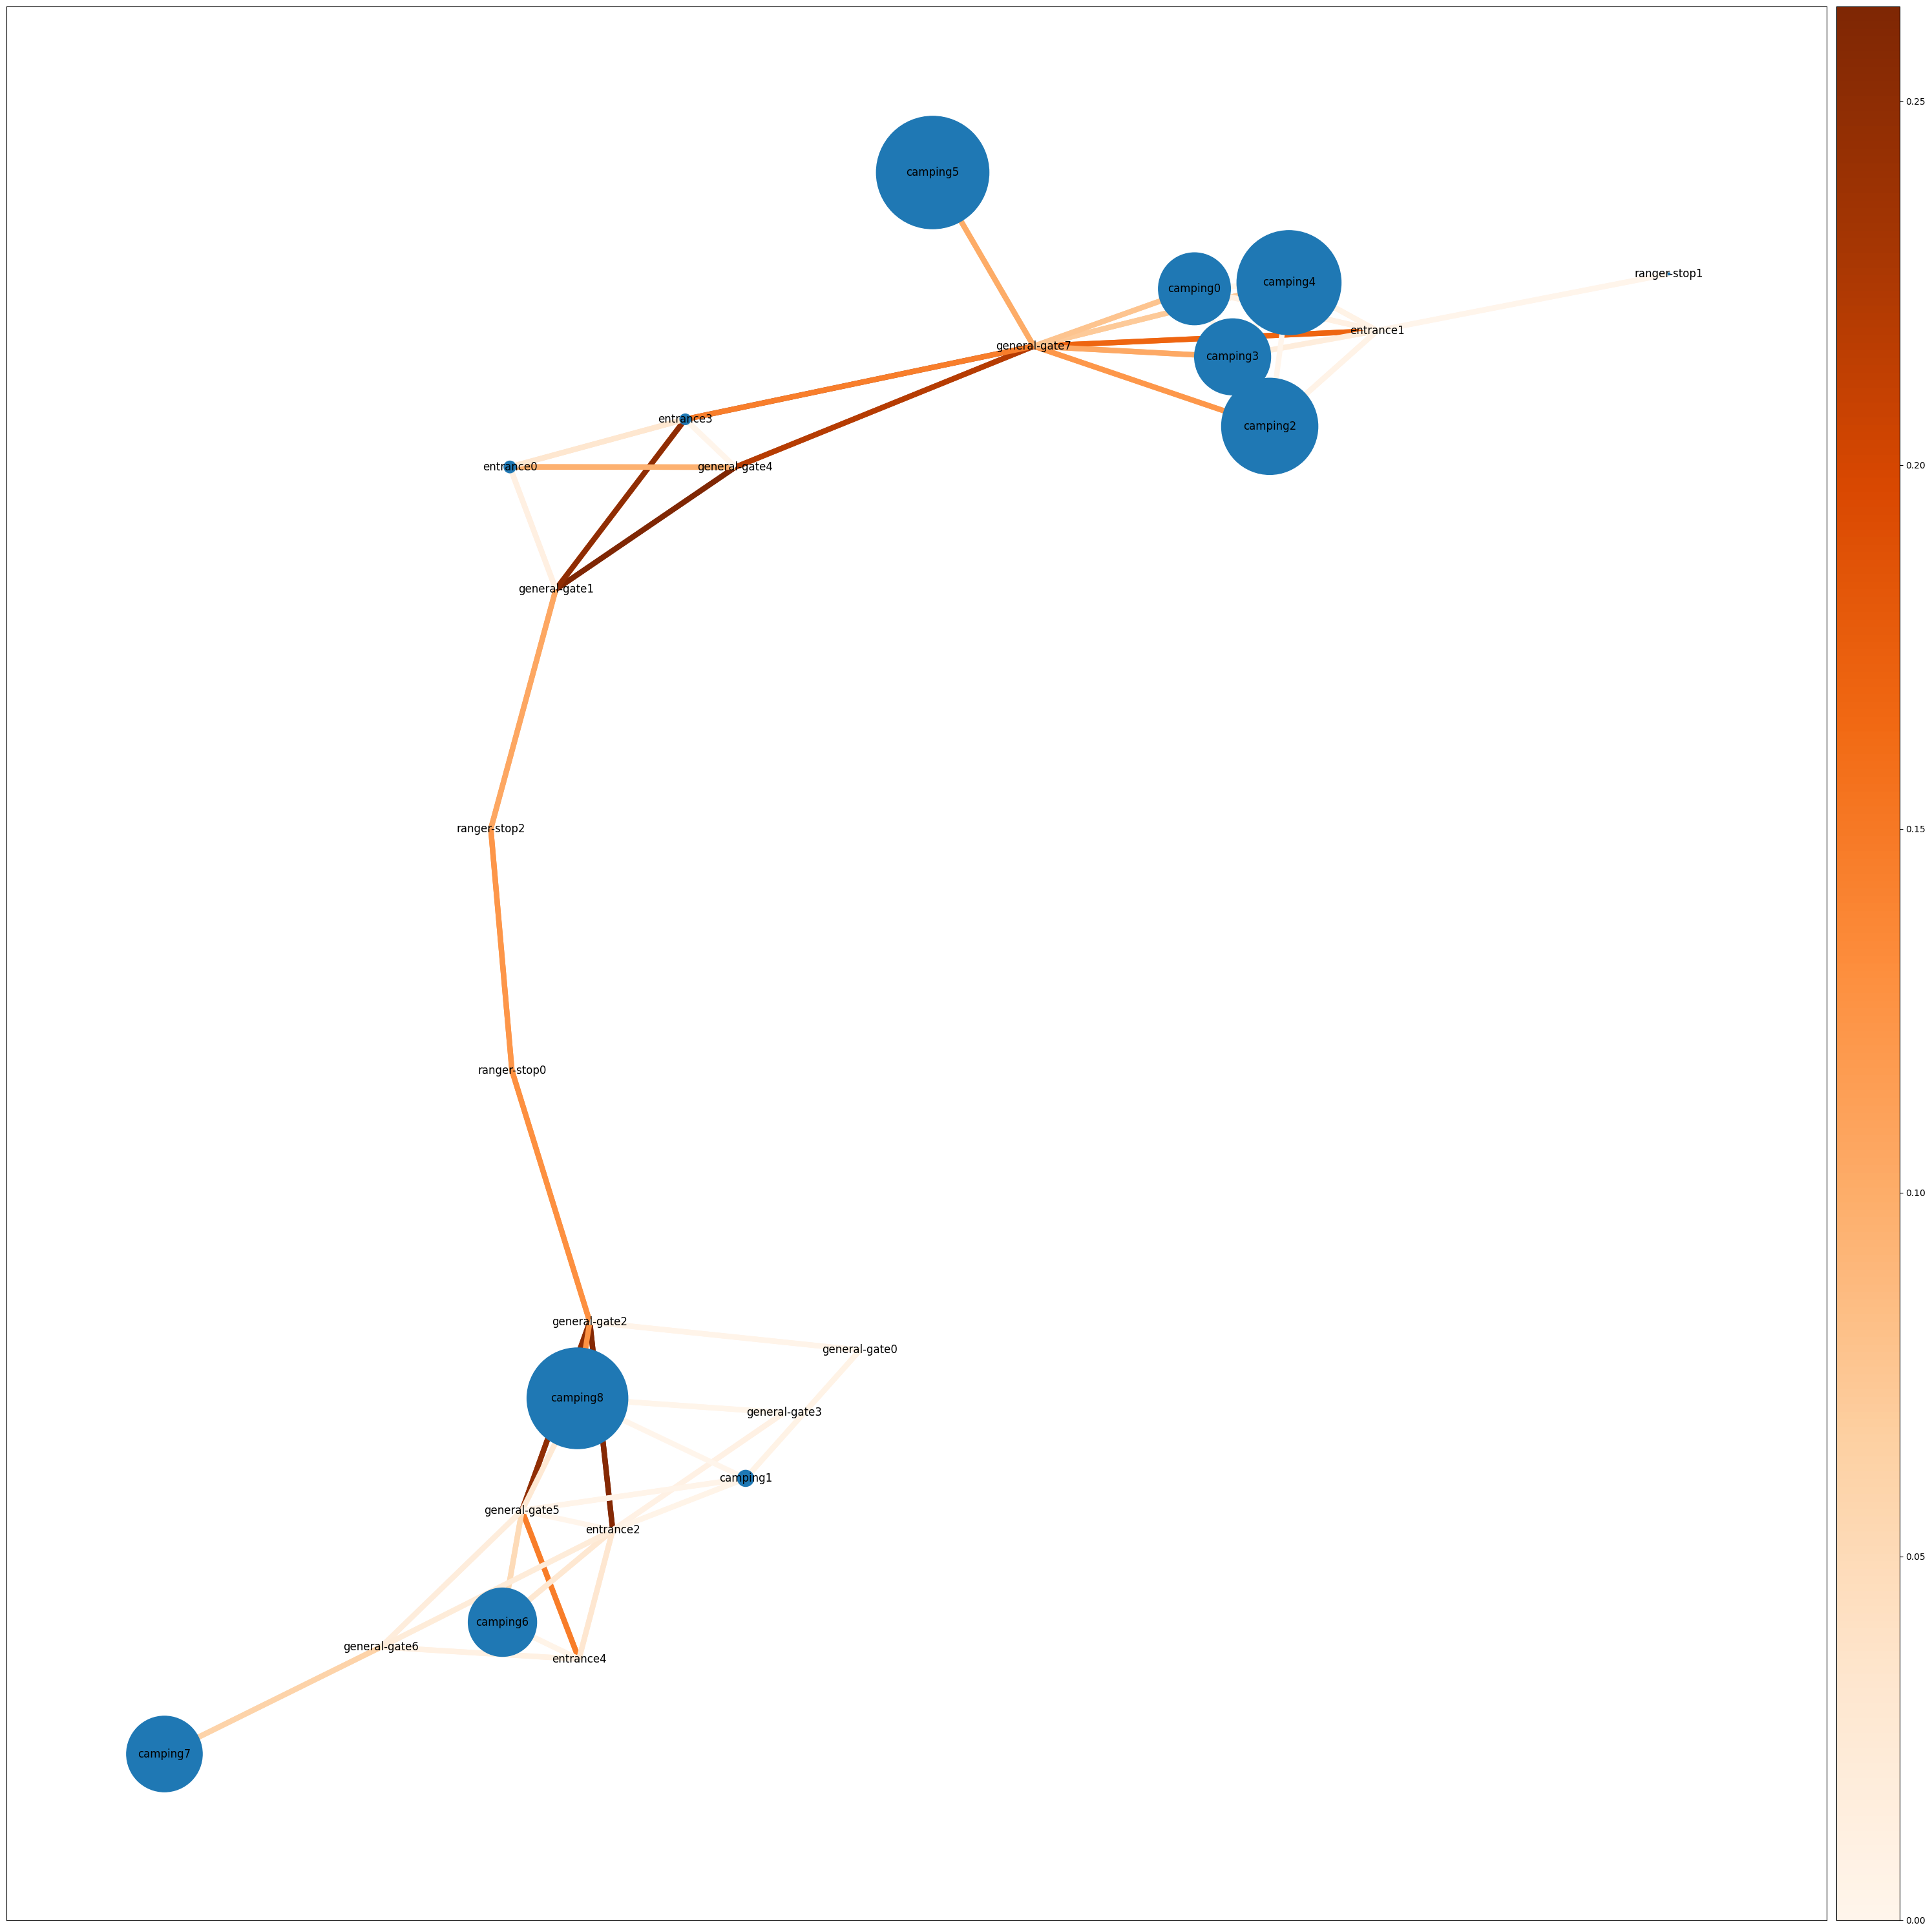

In [38]:
fig, ax = plt.subplots(1,2, figsize=(30,30), tight_layout=True,gridspec_kw={'width_ratios': [29, 1]}) 
pos = nx.spring_layout(graph,seed=63)
n_colors = n_edge_weights[0]
sl_colors = sl_edge_weights[0]

n_my_cmap = plt.cm.Oranges
sl_my_cmap = plt.cm.Blues

n_options = {
    "edge_color": n_colors,
    "width" : 6,
    "edge_cmap": n_my_cmap
}

sl_options = {
    "edge_color": sl_colors,
    "width" : 6,
    "edge_cmap": sl_my_cmap
}


nx.draw_networkx_nodes(graph, pos,nodelist=all_nodes, cmap=plt.get_cmap('jet'), node_size = node_weights,ax=ax[0])
nx.draw_networkx_labels(graph, pos,ax= ax[0])
nx.draw_networkx_edges(graph, pos, edgelist= n_edge_names, arrows=False,ax=ax[0],**n_options)
# nx.draw_networkx_edges(graph, pos, edgelist= sl_edge_names, arrows=False,ax=ax[0],**sl_options)


n_sm = ScalarMappable(cmap=n_my_cmap, norm=plt.Normalize(0,max(n_edge_weights[0])))
# sl_sm = ScalarMappable(cmap=sl_my_cmap, norm=plt.Normalize(0,max(sl_edge_weights[0])))

n_sm._A = []
# sl_sm._A = []
plt.colorbar(n_sm,ax[1])
# plt.colorbar(sl_sm,ax[2])

plt.show()